In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2
%load_ext Cython
#figsize(20,10)

Populating the interactive namespace from numpy and matplotlib


In [2]:
import sys,os
sys.path.append('..')
sys.path.append('../..')
from backtester import matlab, backtester
from backtester.analysis import *
from backtester.swarms.swarm import Swarm
from backtester.exoinfo import EXOInfo
from backtester.swarms.rankingclasses import RankingClassBase, RankerBestWithCorrel
from exobuilder.data.exostorage import EXOStorage

import pandas as pd
import numpy as np
import scipy
import time
import glob
from pandas.tseries.offsets import *
import pprint

In [3]:
# Loading global setting for MongoDB etc.
from scripts.settings import *

try:
    from scripts.settings_local import *
except:
    pass

storage = EXOStorage(MONGO_CONNSTR, MONGO_EXO_DB)

In [4]:
swm_info = storage.swarms_info()
pp = pprint.PrettyPrinter(indent=4)
pp.pprint(swm_info)

{   '_id': None,
    'alphas': [   'MACross',
                  'RenkoPatterns_no_exit_on_patterns',
                  'VolatilityCompression',
                  'IchimokuCloud',
                  'PointAndFigurePatterns',
                  'SwingPoint',
                  'BollingerBands'],
    'exo_types': [   'BearishCollarBW',
                     'PutSpread',
                     'CallSpread',
                     'BullishCollarBW'],
    'instruments': ['NG', 'CL', 'ES']}


'MACross', 'RenkoPatterns_no_exit_on_patterns', 'SwingPoint'

## Getting swarms using filter

In [5]:
instruments_filter = ['ES']  # Select ALL
#instruments_filter = ['ES', 'CL']
exo_filter = ['Spread'] # Select ALL
#exo_filter = ['BullishCollar']
direction_filter = [-1] # Select ALL
#direction_filter = [1]
alpha_filter = ['*']  # Select ALL
#alpha_filter = ['MaCross', 'PointAndFigurePatterns']

swmdf, swm_data = storage.swarms_list(instruments_filter, direction_filter, alpha_filter, exo_filter)


In [6]:
len(swmdf.columns)

14

In [7]:
[print(s) for s in sorted(swmdf.columns)];

ES_CallSpread_Short_BollingerBands
ES_CallSpread_Short_IchimokuCloud
ES_CallSpread_Short_MACross
ES_CallSpread_Short_PointAndFigurePatterns
ES_CallSpread_Short_RenkoPatterns_no_exit_on_patterns
ES_CallSpread_Short_SwingPoint
ES_CallSpread_Short_VolatilityCompression
ES_PutSpread_Short_BollingerBands
ES_PutSpread_Short_IchimokuCloud
ES_PutSpread_Short_MACross
ES_PutSpread_Short_PointAndFigurePatterns
ES_PutSpread_Short_RenkoPatterns_no_exit_on_patterns
ES_PutSpread_Short_SwingPoint
ES_PutSpread_Short_VolatilityCompression


## Set ranking params

In [8]:
rank_correl_threshold = 0.5 # Default = 0.5
rank_window_size = 90       # Default = -1

## Processsing swarm ranks

In [9]:
def process_swarm_rank(swarm_filename):    
    swm = Swarm.load(filename=swarm_filename)
    print("Loading: {0}".format(swm.name))
    swm.context['swarm']['ranking_class'] = RankerBestWithCorrel(window_size=rank_window_size,
                                                                 correl_threshold=rank_correl_threshold)


    old_picked_equity = swm.picked_equity
    swm.pick()
    new_picked_equity = swm.picked_equity
    raw_equity = swm.raw_equity

    eq_df = pd.DataFrame({'new': new_picked_equity, 'old': old_picked_equity, 'raw': raw_equity})
    delta = eq_df['new'] - eq_df['old']
    
    eq_stats = {
        'avg_delta': delta.mean()
    }
    
    return swm.name, eq_df, eq_stats

In [10]:
#%%timeit

TMQRPATH = os.getenv("TMQRPATH", '')
print('Swarms List')

swarms_equities = {}
swarms_stats = {}
for file in swmdf.columns:
    swarm_name = file.replace('.swm','')
    fn = os.path.join(TMQRPATH, 'swarms', file + '.swm')
    try:
        swarm_name, swarm_eq, swarm_stat = process_swarm_rank(fn)        
        swarms_equities[swarm_name] = swarm_eq
        swarms_stats[swarm_name] = swarm_stat
    except FileNotFoundError:
        print('{0} not found'.format(fn))
        
swarm_stats = pd.DataFrame(swarms_stats).T

Swarms List
Loading: ES_CallSpread_Short_BollingerBands
Loading: ES_CallSpread_Short_IchimokuCloud
Loading: ES_CallSpread_Short_MACross
Loading: ES_CallSpread_Short_PointAndFigurePatterns
Loading: ES_CallSpread_Short_RenkoPatterns_no_exit_on_patterns
Loading: ES_CallSpread_Short_SwingPoint
Loading: ES_CallSpread_Short_VolatilityCompression
Loading: ES_PutSpread_Short_BollingerBands
Loading: ES_PutSpread_Short_IchimokuCloud
Loading: ES_PutSpread_Short_MACross
Loading: ES_PutSpread_Short_PointAndFigurePatterns
Loading: ES_PutSpread_Short_RenkoPatterns_no_exit_on_patterns
Loading: ES_PutSpread_Short_SwingPoint
Loading: ES_PutSpread_Short_VolatilityCompression


## Calculating difference between new and old equities

##### Note: greater value of avg_delta means that NEW ranking parameters better than default

delta = new_equity - old_equity

avg_delta = mean(delta)

In [11]:
pd.DataFrame(swarms_stats).T.sort_values(by='avg_delta')

,avg_delta
ES_CallSpread_Short_RenkoPatterns_no_exit_on_patterns,-5464.687566
ES_CallSpread_Short_PointAndFigurePatterns,-5041.521198
ES_CallSpread_Short_SwingPoint,-3224.963766
ES_CallSpread_Short_BollingerBands,-2278.761515
ES_PutSpread_Short_RenkoPatterns_no_exit_on_patterns,-1188.435129
ES_PutSpread_Short_IchimokuCloud,-1160.391786
ES_PutSpread_Short_VolatilityCompression,-1112.443642
ES_CallSpread_Short_IchimokuCloud,-774.908487
ES_CallSpread_Short_MACross,-771.885865
ES_PutSpread_Short_SwingPoint,1201.213524


## Graph of equity deltas for each swarm

##### Note: greater value of delta means that NEW ranking parameters better than default

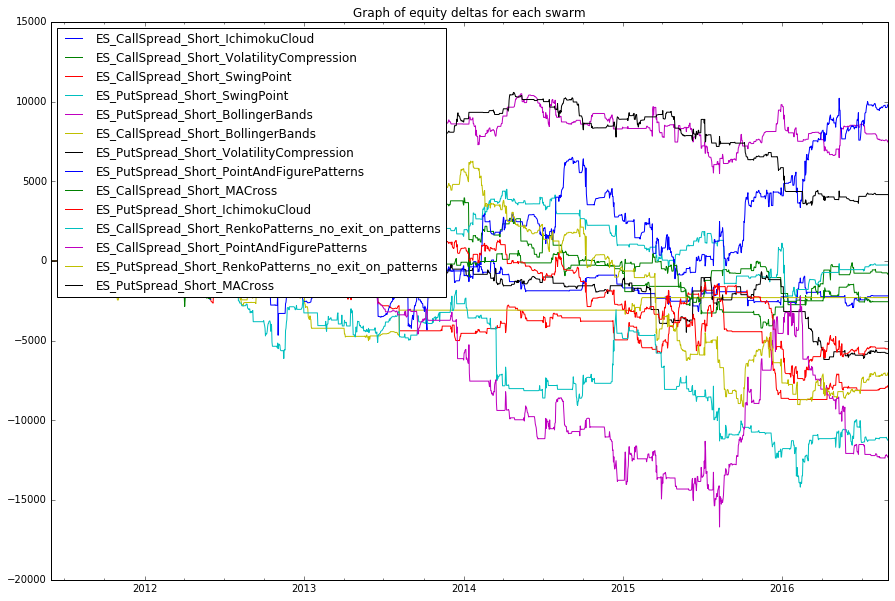

In [12]:
figsize(15, 10)
for s, eq_df in swarms_equities.items():
    delta  = eq_df['new'] - eq_df['old']
    
    delta.plot(label=s)
legend(loc=2);
title('Graph of equity deltas for each swarm');

## Pairwise graphs for all swarms

#### Note: 'raw' equity line (red) is an average of all swarm equities

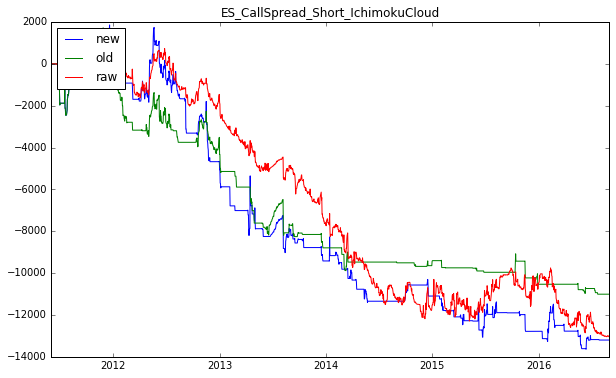

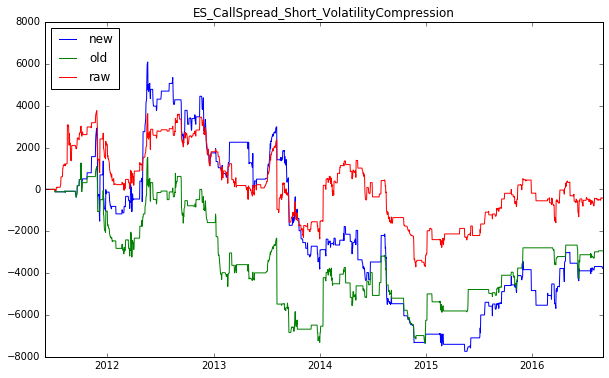

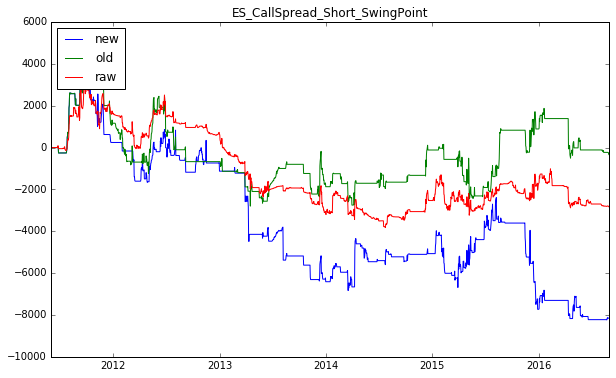

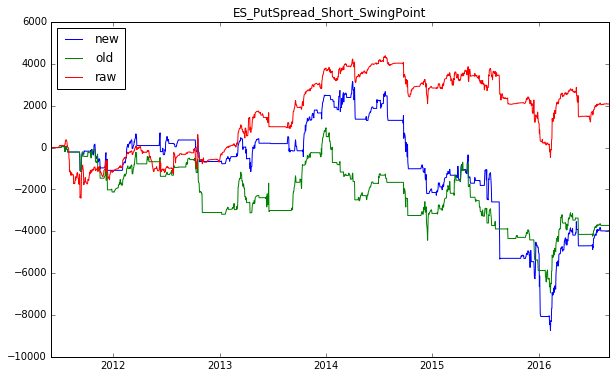

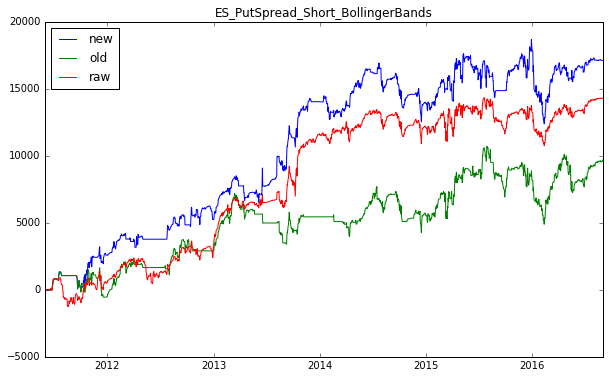

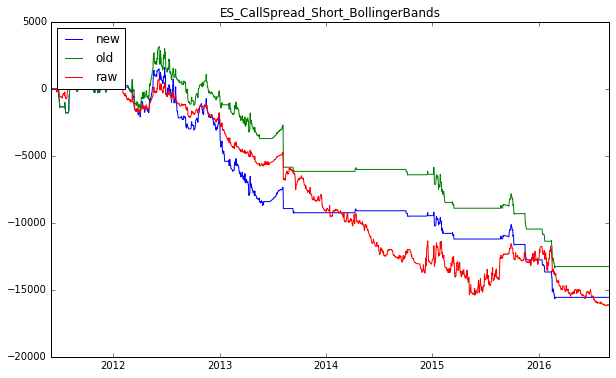

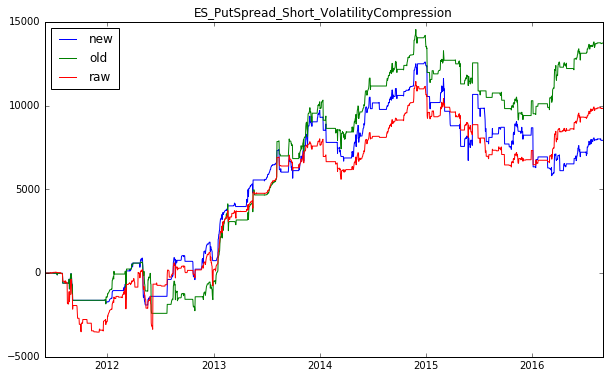

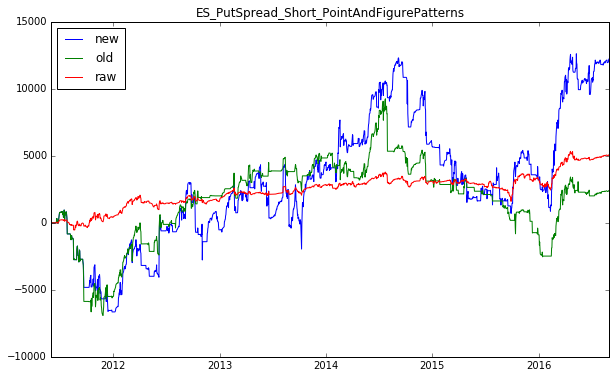

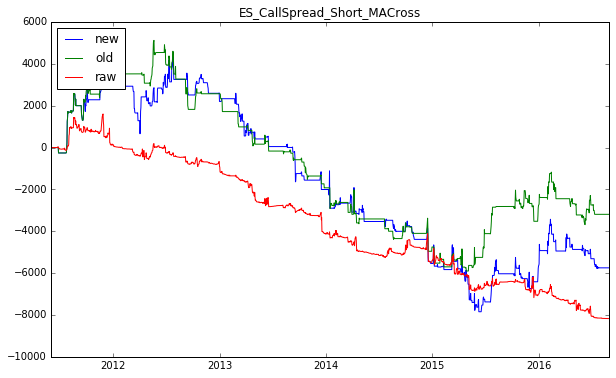

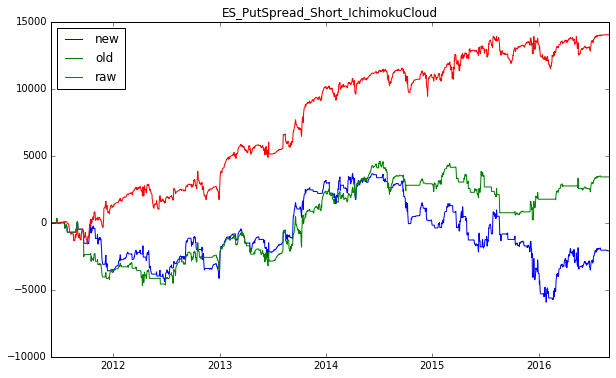

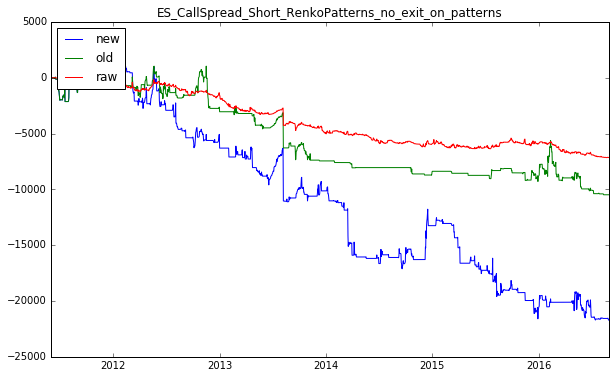

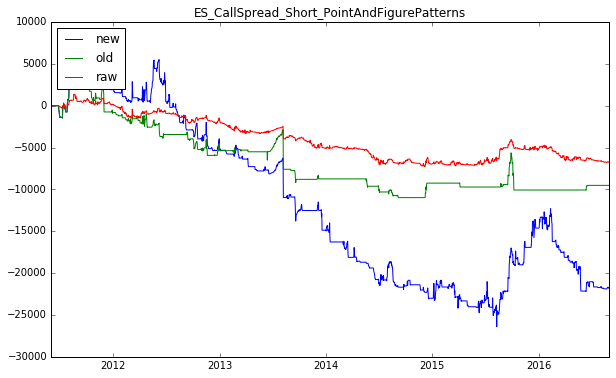

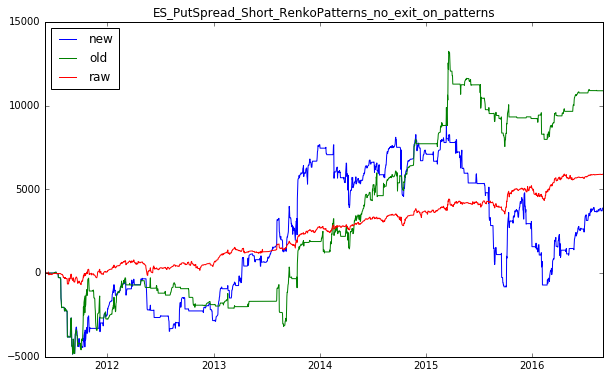

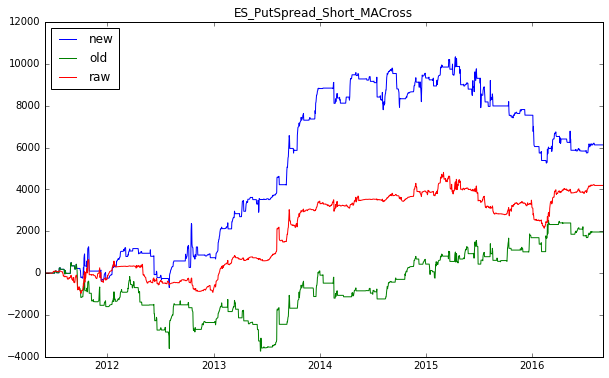

In [13]:
figsize(10, 6)
fig_index = 1
for s, eq_df in swarms_equities.items():
    f = plt.figure(fig_index)
    plt.plot(eq_df['new'], label='new');
    plt.plot(eq_df['old'], label='old');
    plt.plot(eq_df['raw'], label='raw');
    plt.legend(loc=2)
    plt.title(s);
    fig_index += 1


In [14]:
pd.Panel(swarms_equities)

<class 'pandas.core.panel.Panel'>
Dimensions: 14 (items) x 1918 (major_axis) x 3 (minor_axis)
Items axis: ES_CallSpread_Short_BollingerBands to ES_PutSpread_Short_VolatilityCompression
Major_axis axis: 2011-06-01 00:00:00 to 2016-08-30 00:00:00
Minor_axis axis: new to raw

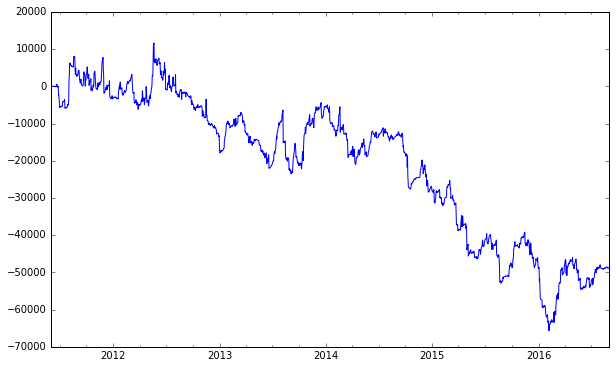

In [15]:
equity_ranked = {}
for s, eq_df in swarms_equities.items():
    equity_ranked[s] = eq_df['new']
pd.DataFrame(equity_ranked).sum(axis=1).plot()